In [1]:
import os.path
baseDir = os.path.join('Data')
inputPath = os.path.join('projeto', 'expCorretos.txt')
fileName = os.path.join(baseDir, inputPath)
#abrir o arquivo
if os.path.isfile(fileName):
    rawData = (sc
               .textFile(fileName, 50))  


In [2]:
#O arquivo é o log de uma aplicação sink que faz o log de um broker mqtt
#então é necessário realizar algumas manipulaçoes de pre-processamento

#função responsável por fazer o parse de cada mensagem dos sensores
def parseMessage(msg):
    msg = msg.split(";")
    for i in range(0,len(msg)):
        msg[i] = msg[i].split("=")[1]
    return msg
#depois de fazer o parse das mensagens, iremos filtar só aquelas que nos interessam
processedAllData = rawData.map(parseMessage).filter(lambda msg: msg[0]==u'poste')
print processedAllData.take(2)

[[u'poste', u'1', u'dia', u'0.38485343993385845', u'1512616176428'], [u'poste', u'92233', u'dia', u'0.14662803797791926', u'1512616176442']]


In [3]:
#cada mensagem tem muitos atributos, não precisamos de todos eles, iremos precisar
#da informação de se é dia ou noite (filtraremos por ela) e só precisaremos do payload
processedDataDia = processedAllData.filter(lambda x: x[2]==u'dia').map(lambda x: float(x[3]))
processedDataNoite = processedAllData.filter(lambda x: x[2]=='noite').map(lambda x: float(x[3]))

print processedDataDia.take(2)
print processedDataNoite.take(2)

cached processedData
[0.38485343993385845, 0.14662803797791926]
[0.8884692653425237, 0.9028595972926372]


In [4]:
#agora que temos os dados processados, vamos calcular a media e a variancia dessa bd

#para o dia:
mediaDia = processedDataDia.mean()
varDia = processedDataDia.variance()
lenghtDia = processedDataDia.count()
print ('Mean Day: %f' %mediaDia)
print ('Var day: %f' %varDia)
print ('Lenght day: %f' %lenghtDia)

#para a noite:
mediaNoite = processedDataNoite .mean()
varNoite  = processedDataNoite .variance()
lenghtNoite  = processedDataNoite .count()
print ('Mean Night: %f' %mediaNoite)
print ('Var Night: %f' %varNoite)
print ('Lenght Night: %f' %lenghtNoite)


Mean Day: 0.208265
Var day: 0.021953
Lenght day: 12702735.000000
Mean Night: 0.697567
Var Night: 0.024837
Lenght Night: 8696659.000000


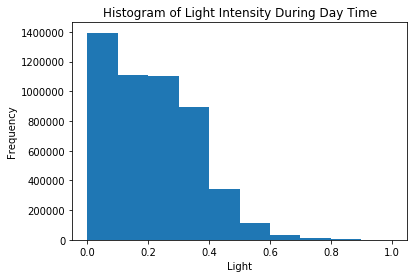

In [11]:
import plotly.plotly as py
import matplotlib.pyplot as plt
import numpy as np

dataDia = processedDataDia.take(5000000)
plt.hist(dataDia)
plt.title("Histogram of Light Intensity During Day Time")
plt.xlabel("Light")
plt.ylabel("Frequency")
fig1 = plt.gcf()
pass


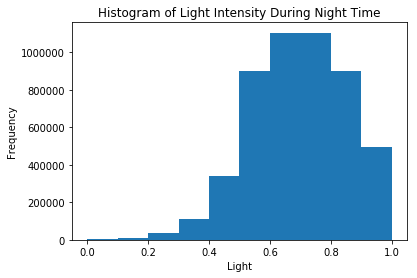

In [8]:
dataNoite = processedDataNoite.take(5000000)
plt.hist(dataNoite)
plt.title("Histogram of Light Intensity During Night Time")
plt.xlabel("Light")
plt.ylabel("Frequency")
fig2 = plt.gcf()
pass

In [45]:
#Agora faremos um processo analogo ao feito até aqui para o conjunto de dados da Cross validation
# ele será usado para ajustar o valor de epsilon, que será nosso threshold para detectar anomalias
baseDir = os.path.join('Data')
inputPath = os.path.join('projeto','crossValidation.txt')
fileName = os.path.join(baseDir, inputPath)
#abrir o arquivo
if os.path.isfile(fileName):
    rawCrossData = (sc
               .textFile(fileName, 10))

processedCrossData = rawCrossData.map(parseMessage).filter(lambda msg: msg[0]==u'poste')
crossDataDia = processedCrossData.filter(lambda x: x[2]==u'dia').map(lambda x: (float(x[3]), float(x[4])))
crossDataNoite = processedCrossData.filter(lambda x: x[2]==u'noite').map(lambda x: (float(x[3]), float(x[4])))
crossDataDia.cache()
crossDataNoite.cache()

print crossDataDia.take(1)
print crossDataNoite.take(1)

[(0.007116127474472015, 0.0)]
[(0.7785136755656221, 0.0)]


In [58]:
#Agora vamos fazer duas funções, a primeira calcula a gaussiana dado um x
#a segunda detecta se um dado elemento é uma anomalia ou não
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))


#anomalia = 1 normal = 0
def detectClassDay( x, epsilon):
    test = gaussian(x, mediaDia, varDia)
    if(test > epsilon):
        return 0.0
    else:
        return 1.0
    
def detectClassNoite( x, epsilon):
    test = gaussian(x, mediaNoite, varNoite)
    if(test > epsilon):
        return 0.0
    else:
        return 1.0
    


In [40]:
#Agora vamos fazer o processo de cross validation para definir um epsilon ideal para
#nosso conjunto de dados, para isso utilizaremos do f1 (Precision and recall)

def testaPrecision(pred, classe):
    if pred==classe:
        return 1.0
    else:
        return 0.0
    
def testaRecall(pred, classe):
    if pred==1.0 and classe==1.0:
        return 1.0
    else:
        return 0.0

In [68]:
melhorF1Dia=0
melhorF1Noite=0
melhorEpsilonDia=0
melhorEpsilonNoite=0

epsilons = (1.0527717316e-90,1.0527717316e-80,1.0527717316e-70,1.0527717316e-50,1.0527717316e-30, 1.0527717316e-20)
for epsilon in epsilons:
    classCrossDataDia = crossDataDia.map(lambda (pred,classe): (detectClassDay( pred,epsilon ),classe))                                    
    classCrossDataNoite = crossDataNoite.map(lambda (pred,classe): (detectClassNoite(pred,epsilon ),classe))
    
    
    precisionDia = classCrossDataDia.map(lambda (p,c): testaPrecision(p,c)).reduce(lambda x,y: x+y)
    precisionDia = precisionDia/qntDia
    recall = classCrossDataDia.map(lambda (p,c): testaRecall(p,c)).reduce(lambda x,y: x+y)
    recallDia = recall/recallCountDia
    fDia= (precisionDia*recallDia)/(precisionDia+recallDia)
    
    precisionNoite = classCrossDataNoite.map(lambda (p,c): testaPrecision(p,c)).reduce(lambda x,y: x+y)
    precisionNoite = precisionNoite/qntNoite
    recall = classCrossDataNoite.map(lambda (p,c): testaRecall(p,c)).reduce(lambda x,y: x+y)
    recallNoite = recall/recallCountNoite
    fNoite= (precisionNoite*recallNoite)/(precisionNoite+recallNoite)
    
    print "DIA:"
    print "precision"
    print precisionDia
    print "recall"
    print recallDia
    print "f1"
    print fDia
    print ('-'*40)
    print "NOITE:"
    print "precision"
    print precisionNoite
    print "recall"
    print recallNoite
    print "f1"
    print fNoite
    print ('-'*40)
    
    if fDia > melhorF1Dia:
        melhorF1Dia=fDia
        melhorEpsilonDia=epsilon
    if fNoite > melhorF1Noite:
        melhorF1Noite=fNoite
        melhorEpsilonNoite=epsilon
        
print ('*'*50)
print ('Melhor epsilon DIA:')
print (melhorEpsilonDia)
print ('melhor f1 dia: %f' %melhorF1Dia)
print ('-'*50)
print ('melhor epsilon NOITE:' )
print (melhorEpsilonNoite)
print ('melhor f1 noite: %f' %melhorF1Noite)

DIA:
precision
0.991182814875
recall
1.0
f1
0.497785942843
----------------------------------------
NOITE:
precision
0.99204846962
recall
0.836030093785
f1
0.453690772212
----------------------------------------
Para epsilon de valor:
1.0527717316e-70
melhor epsilon: 0.000000
melhor f1 dia: 0.497786
melhor f1 noite: 0.453691
----------------------------------------
DIA:
precision
0.981357162875
recall
1.0
f1
0.495295437523
----------------------------------------
NOITE:
precision
0.988376466115
recall
1.0
f1
0.497077129487
----------------------------------------
Para epsilon de valor:
1.0527717316e-50
melhor epsilon: 0.000000
melhor f1 dia: 0.497786
melhor f1 noite: 0.497077
----------------------------------------
DIA:
precision
0.954852530296
recall
1.0
f1
0.488452461502
----------------------------------------
NOITE:
precision
0.933199292463
recall
1.0
f1
0.48272275709
----------------------------------------
Para epsilon de valor:
1.0527717316e-30
melhor epsilon: 0.000000
melhor f

In [69]:

melhorEpsilon = 1.0527717316e-75 
#o processamento da célula acima demora muito e não quero reprocessa-la 
#toda vez que reinicio o notebook

#finalmente o teste final
baseDir = os.path.join('Data')
inputPath = os.path.join('projeto','Test.txt')
fileName = os.path.join(baseDir, inputPath)
#abrir o arquivo
if os.path.isfile(fileName):
    rawTestData = (sc.textFile(fileName, 10))

processedTestData = rawTestData.map(parseMessage).filter(lambda msg: msg[0]==u'poste')
testDataDia = processedTestData.filter(lambda x: x[2]==u'dia').map(lambda x: (float(x[3]), float(x[4])))
testDataNoite = processedTestData.filter(lambda x: x[2]==u'noite').map(lambda x: (float(x[3]), float(x[4])))

print testDataDia.take(1)
print testDataNoite.take(1)

classTestDataDia = testDataDia.map(lambda (pred,classe): (detectClassDay(pred,melhorEpsilon ),classe))                                    
classTestDataNoite = testDataNoite.map(lambda (pred,classe): (detectClassNoite( pred,melhorEpsilon),classe)) 

precisionDia = classTestDataDia.map(lambda (p,c): testaPrecision(p,c)).reduce(lambda x,y: x+y)
precisionCount = classTestDataDia.count()
precisionDia = precisionDia/precisionCount
recall = classTestDataDia.map(lambda (p,c): testaRecall(p,c)).reduce(lambda x,y: x+y)
recallCount = classTestDataDia.map(lambda (p,classe): classe).reduce(lambda x,y:x+y)
recallDia = recall/recallCount
fDia= (precisionDia*recallDia)/(precisionDia+recallDia)

precisionNoite = classTestDataNoite.map(lambda (p,c): testaPrecision(p,c)).reduce(lambda x,y: x+y)
precisionCount = classTestDataNoite.count()
precisionNoite = precisionNoite/precisionCount
recall = classTestDataNoite.map(lambda (p,c): testaRecall(p,c)).reduce(lambda x,y: x+y)
recallCount = classTestDataNoite.map(lambda (p,classe): classe).reduce(lambda x,y:x+y)
recallNoite = recall/recallCount
fNoite= (precisionNoite*recallNoite)/(precisionNoite+recallNoite)

print "DIA:"
print "precision"
print precisionDia
print "recall"
print recallDia
print "f1"
print fDia
print ('-'*40)
print "NOITE:"
print "precision"
print precisionNoite
print "recall"
print recallNoite
print "f1"
print fNoite
print ('-'*40)



[(0.20564404834358851, 0.0)]
[(0.7702182139213366, 0.0)]
DIA:
precision
0.979314994926
recall
0.321572372496
f1
0.242081408603
----------------------------------------
NOITE:
precision
0.996178525181
recall
0.999896544589
f1
0.499017036086
----------------------------------------


[(0.5701274771195805, 1.0), (0.605856229258862, 1.0), (0.2708739377655436, 1.0), (0.2007643098612864, 1.0), (0.10473483340538864, 1.0), (0.32671023710626634, 1.0), (0.8067344805363831, 1.0), (0.21810144266387219, 1.0), (0.32706972896238445, 1.0), (0.13874155483578926, 1.0)]


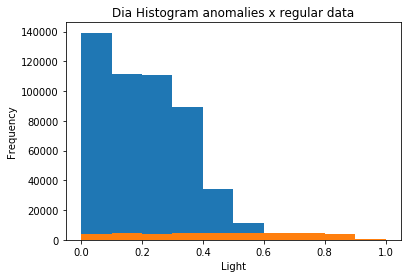

In [72]:
erros = testDataDia.filter(lambda (value,c): c==1.0 )
print erros.take(10)
erros = erros.map(lambda (value,c): value)
erros = erros.take(100000)

acertos =  testDataDia.filter(lambda (value,c): c==0.0 ).map(lambda (value,c): value)
acertos = acertos.take(500000)
plt.hist(acertos)
plt.hist(erros)
plt.title("Dia Histogram anomalies x regular data")
plt.xlabel("Light")
plt.ylabel("Frequency")
fig2 = plt.gcf()
pass

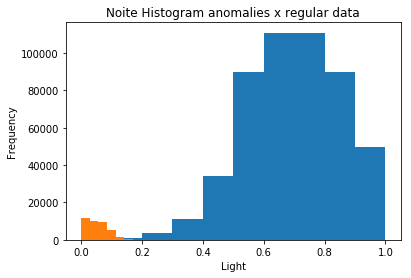

In [73]:
erros = testDataNoite.filter(lambda (value,c): c==1.0 ).map(lambda (value,c): value)
erros = erros.take(100000)
acertos =  testDataNoite.filter(lambda (value,c): c==0.0 ).map(lambda (value,c): value)
acertos = acertos.take(500000)
plt.hist(acertos)
plt.hist(erros)
plt.title("Noite Histogram anomalies x regular data")
plt.xlabel("Light")
plt.ylabel("Frequency")
fig2 = plt.gcf()
pass

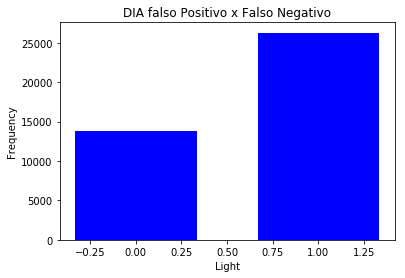

In [74]:
falsoPositivo = classTestDataDia.filter(lambda (p,c): p==1.0 and c==0.0).count()
falsoNegativo = classTestDataDia.filter(lambda (p,c): p==0.0 and c==1.0).count()
y = [falsoPositivo, falsoNegativo]
N = len(y)
x = range(N)
width = 1/1.5
plt.bar(x, y, width, color="blue")
plt.title("DIA falso Positivo x Falso Negativo")
plt.xlabel("Light")
plt.ylabel("Frequency")
fig = plt.gcf()
pass

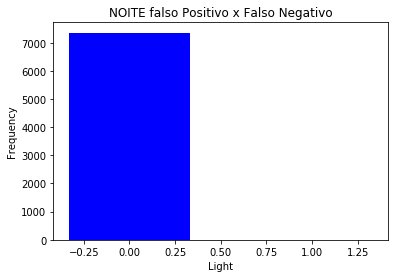

In [76]:
falsoPositivo = classTestDataNoite.filter(lambda (p,c): p==1.0 and c==0.0).count()
falsoNegativo = classTestDataNoite.filter(lambda (p,c): p==0.0 and c==1.0).count()
y = [falsoPositivo, falsoNegativo]
N = len(y)
x = range(N)
width = 1/1.5
plt.bar(x, y, width, color="blue")
plt.title("NOITE falso Positivo x Falso Negativo")
plt.xlabel("Light")
plt.ylabel("Frequency")
fig = plt.gcf()
pass

In [78]:
triplaDia = testDataDia.map(lambda (pred,classe): (pred, detectClassDay(pred,melhorEpsilon ),classe))                                    
negativoCorreto = triplaDia.filter(lambda (value,pred, classe): pred==0.0 and classe==0.0).map(lambda (value,pred,classe): value)
positivoCorreto = triplaDia.filter(lambda (value,pred, classe): pred==1.0 and classe==1.0).map(lambda (value,pred, classe): value)
print negativoCorreto.count()
print positivoCorreto.count()

1885854
12459


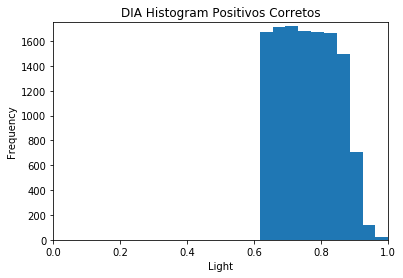

In [82]:
#positivoCorreto = positivoCorreto.take(12459)
plt.hist(positivoCorreto)
plt.title("DIA Histogram Positivos Corretos")
plt.xlabel("Light")
plt.ylabel("Frequency")
plt.axis([0.0, 1.0,0,1750 ])

fig2 = plt.gcf()
pass


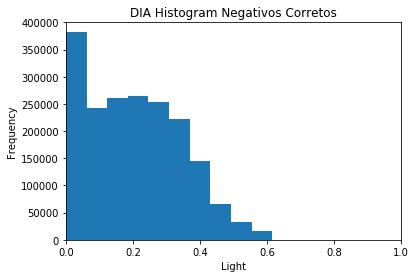

In [84]:
#negativoCorreto = negativoCorreto.take(1885854)
plt.hist(negativoCorreto)
plt.title("DIA Histogram Negativos Corretos")
plt.xlabel("Light")
plt.ylabel("Frequency")
plt.axis([0.0, 1.0,0,400000 ])

fig2 = plt.gcf()
pass


In [38]:

#A métrica F1 foi extremamente ruim, isso é devido a pouca variabilidade dos erros, da forma que eles foram gerados
#boa parte dos erros tem pouca diferença de valores corretos, então foi gerado um novo conjunto de dados com 
#erros maiores
baseDir = os.path.join('Data')
inputPath = os.path.join('projeto','CrossValidationFinal.txt')
fileName = os.path.join(baseDir, inputPath)
#abrir o arquivo
if os.path.isfile(fileName):
    rawCrossData = (sc.textFile(fileName, 10))
processedCrossData = rawCrossData.map(parseMessage).filter(lambda msg: msg[0]==u'poste')
crossDataDia = processedCrossData.filter(lambda x: x[2]==u'dia').map(lambda x: (float(x[3]), float(x[4])))
crossDataNoite = processedCrossData.filter(lambda x: x[2]==u'noite').map(lambda x: (float(x[3]), float(x[4])))

print "DIA:"
print crossDataDia.take(2)
print "NOITE:"
print crossDataNoite.take(2)



DIA:
[(0.1272537648529523, 0.0), (0.21843860370189444, 0.0)]
NOITE:
[(0.38322918163857855, 0.0), (0.7966660232870342, 0.0)]


In [56]:
#vamos descobrir algumas infos importantes da nossa base de cross validation
recallCountDia = crossDataDia.map(lambda (p,classe): classe).reduce(lambda x,y:x+y)
recallCountNoite = crossDataNoite.map(lambda (p,classe): classe).reduce(lambda x,y:x+y)
qntDia = crossDataDia.count()
qntNoite = crossDataNoite.count()
print ('qnt de valores dia %f '%qntDia)
print ('qnt erros dia: %f' %recallCountDia)
print ('qnt de valores noite %f '%qntNoite)
print ('qnt erros noite: %f' %recallCountNoite)

qnt de valores dia 471012.000000 
qnt erros dia: 9285.000000
qnt de valores noite 483932.000000 
qnt erros noite: 9703.000000


In [64]:
melhorF1Dia=0
melhorF1Noite=0
melhorEpsilonDia=0
melhorEpsilonNoite=0

epsilons = (1.0527717316e-100,1.0527717316e-90,1.0527717316e-80,1.0527717316e-70, 1.0527717316e-50)
for epsilon in epsilons:
    classCrossDataDia = crossDataDia.map(lambda (pred,classe): (detectClassDay( pred,epsilon ),classe))                                    
    classCrossDataNoite = crossDataNoite.map(lambda (pred,classe): (detectClassNoite(pred,epsilon ),classe))
    
    precisionDia = classCrossDataDia.map(lambda (p,c): testaPrecision(p,c)).reduce(lambda x,y: x+y)
    precisionDia = precisionDia/qntDia
    recall = classCrossDataDia.map(lambda (p,c): testaRecall(p,c)).reduce(lambda x,y: x+y)
    recallDia = recall/recallCountDia
    fDia= (precisionDia*recallDia)/(precisionDia+recallDia)
    
    precisionNoite = classCrossDataNoite.map(lambda (p,c): testaPrecision(p,c)).reduce(lambda x,y: x+y)
    precisionNoite = precisionNoite/qntNoite
    recall = classCrossDataNoite.map(lambda (p,c): testaRecall(p,c)).reduce(lambda x,y: x+y)
    recallNoite = recall/recallCountNoite
    fNoite= (precisionNoite*recallNoite)/(precisionNoite+recallNoite)
    
    print "DIA:"
    print "precision"
    print precisionDia
    print "recall"
    print recallDia
    print "f1"
    print fDia
    print ('-'*40)
    print "NOITE:"
    print "precision"
    print precisionNoite
    print "recall"
    print recallNoite
    print "f1"
    print fNoite
    print ('-'*40)
    
    if fDia > melhorF1Dia:
        melhorF1Dia=fDia
        melhorEpsilonDia=epsilon
    if fNoite > melhorF1Noite:
        melhorF1Noite=fNoite
        melhorEpsilonNoite=epsilon
        
    print ('Para epsilon de valor:')
    print(epsilon)
    print ('melhor epsilon: %f' %melhorEpsilonNoite)
    print ('melhor f1 dia: %f' %melhorF1Dia)
    print ('melhor f1 noite: %f' %melhorF1Noite)
    print ('-'*40)
    
print ('*'*50)
print ('Melhor epsilon DIA:')
print (melhorEpsilonDia)
print ('melhor f1 dia: %f' %melhorF1Dia)
print ('-'*50)
print ('melhor epsilon NOITE:' )
print (melhorEpsilonNoite)
print ('melhor f1 noite: %f' %melhorF1Noite)


DIA:
precision
0.996946999227
recall
1.0
f1
0.499235582924
----------------------------------------
NOITE:
precision
0.989424133969
recall
0.541378954962
f1
0.349916594457
----------------------------------------
Para epsilon de valor:
1.0527717316e-100
melhor epsilon: 0.000000
melhor f1 dia: 0.499236
melhor f1 noite: 0.349917
----------------------------------------
DIA:
precision
0.995658284715
recall
1.0
f1
0.498912209741
----------------------------------------
NOITE:
precision
0.990620583057
recall
0.635061321241
f1
0.386979036096
----------------------------------------
Para epsilon de valor:
1.0527717316e-90
melhor epsilon: 0.000000
melhor f1 dia: 0.499236
melhor f1 noite: 0.386979
----------------------------------------
DIA:
precision
0.993838798162
recall
1.0
f1
0.498454939827
----------------------------------------
NOITE:
precision
0.991571129828
recall
0.733278367515
f1
0.421542668201
----------------------------------------
Para epsilon de valor:
1.0527717316e-80
melhor e

In [88]:
#novamente, só para não precisar rodar a celula acima toda hora
melhorEpsilonDia = 1.0527717316e-100
melhorEpsilonNoite= 1.0527717316e-100

#finalmente o teste final
baseDir = os.path.join('Data')
inputPath = os.path.join('projeto','TestFinal.txt')
fileName = os.path.join(baseDir, inputPath)
#abrir o arquivo
if os.path.isfile(fileName):
    rawTestData = (sc.textFile(fileName, 10))

processedTestData = rawTestData.map(parseMessage).filter(lambda msg: msg[0]==u'poste')
testDataDia = processedTestData.filter(lambda x: x[2]==u'dia').map(lambda x: (float(x[3]), float(x[4])))
testDataNoite = processedTestData.filter(lambda x: x[2]==u'noite').map(lambda x: (float(x[3]), float(x[4] )))

print testDataDia.take(1)
print testDataNoite.take(1)

classTestDataDia = testDataDia.map(lambda (pred,classe): (detectClassDay(pred,melhorEpsilonDia ),classe))                                    
classTestDataNoite = testDataNoite.map(lambda (pred,classe): (detectClassNoite( pred,melhorEpsilonNoite ),classe)) 

precisionDia = classTestDataDia.map(lambda (p,c): testaPrecision(p,c)).reduce(lambda x,y: x+y)
precisionCount = classTestDataDia.count()
precisionDia = precisionDia/precisionCount
recall = classTestDataDia.map(lambda (p,c): testaRecall(p,c)).reduce(lambda x,y: x+y)
recallCount = classTestDataDia.map(lambda (p,classe): classe).reduce(lambda x,y:x+y)
recallDia = recall/recallCount
fDia= (precisionDia*recallDia)/(precisionDia+recallDia)

precisionNoite = classTestDataNoite.map(lambda (p,c): testaPrecision(p,c)).reduce(lambda x,y: x+y)
precisionCount = classTestDataNoite.count()
precisionNoite = precisionNoite/precisionCount
recall = classTestDataNoite.map(lambda (p,c): testaRecall(p,c)).reduce(lambda x,y: x+y)
recallCount = classTestDataNoite.map(lambda (p,classe): classe).reduce(lambda x,y:x+y)
recallNoite = recall/recallCount
fNoite= (precisionNoite*recallNoite)/(precisionNoite+recallNoite)

print "DIA:"
print "precision"
print precisionDia
print "recall"
print recallDia
print "f1"
print fDia
print ('-'*40)
print "NOITE:"
print "precision"
print precisionNoite
print "recall"
print recallNoite
print "f1"
print fNoite
print ('-'*40)


[(0.2668599995472038, 0.0)]
[(0.7569819801818207, 0.0)]
DIA:
precision
0.997013826789
recall
1.0
f1
0.499252340377
----------------------------------------
NOITE:
precision
0.989770493025
recall
0.542797494781
f1
0.350552111421
----------------------------------------


[(0.9002547800540924, 1.0), (0.8902557015419006, 1.0), (0.9180454790592194, 1.0), (0.8363217175006866, 1.0), (0.7140890717506408, 1.0), (0.7127061069011688, 1.0), (0.850052285194397, 1.0), (0.832487142086029, 1.0), (0.91936696767807, 1.0), (0.9648723244667053, 1.0)]


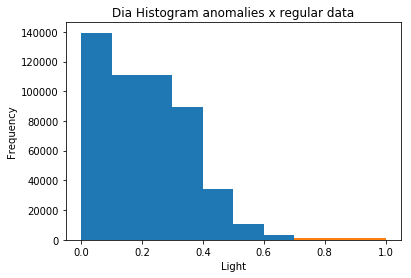

In [89]:
erros = testDataDia.filter(lambda (value,c): c==1.0 )
print erros.take(10)
erros = erros.map(lambda (value,c): value)
erros = erros.take(100000)

acertos =  testDataDia.filter(lambda (value,c): c==0.0 ).map(lambda (value,c): value)
acertos = acertos.take(500000)
plt.hist(acertos)
plt.hist(erros)
plt.title("Dia Histogram anomalies x regular data")
plt.xlabel("Light")
plt.ylabel("Frequency")
fig2 = plt.gcf()
pass

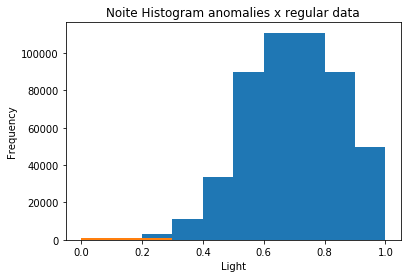

In [90]:
erros = testDataNoite.filter(lambda (value,c): c==1.0 ).map(lambda (value,c): value)
erros = erros.take(100000)
acertos =  testDataNoite.filter(lambda (value,c): c==0.0 ).map(lambda (value,c): value)
acertos = acertos.take(500000)
plt.hist(acertos)
plt.hist(erros)
plt.title("Noite Histogram anomalies x regular data")
plt.xlabel("Light")
plt.ylabel("Frequency")
fig2 = plt.gcf()
pass

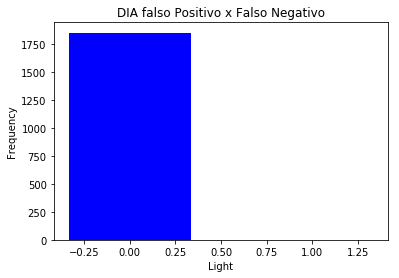

In [91]:
falsoPositivo = classTestDataDia.filter(lambda (p,c): p==1.0 and c==0.0).count()
falsoNegativo = classTestDataDia.filter(lambda (p,c): p==0.0 and c==1.0).count()
y = [falsoPositivo, falsoNegativo]
N = len(y)
x = range(N)
width = 1/1.5
plt.bar(x, y, width, color="blue")
plt.title("DIA falso Positivo x Falso Negativo")
plt.xlabel("Light")
plt.ylabel("Frequency")
fig = plt.gcf()
pass

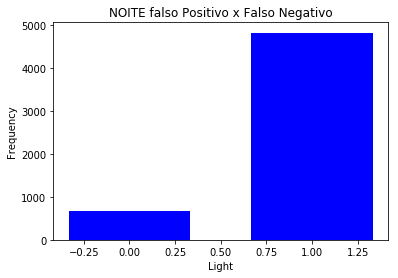

In [92]:
falsoPositivo = classTestDataNoite.filter(lambda (p,c): p==1.0 and c==0.0).count()
falsoNegativo = classTestDataNoite.filter(lambda (p,c): p==0.0 and c==1.0).count()
y = [falsoPositivo, falsoNegativo]
N = len(y)
x = range(N)
width = 1/1.5
plt.bar(x, y, width, color="blue")
plt.title("NOITE falso Positivo x Falso Negativo")
plt.xlabel("Light")
plt.ylabel("Frequency")
fig = plt.gcf()
pass